In [169]:
import itertools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import decomposition

import warnings
warnings.filterwarnings('ignore')

In [8]:
def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
    return matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', color_list)

base_color = 'darkturquoise'
base_color2 = 'gray'
cm = generate_cmap([base_color2, 'white', base_color])

In [9]:
reader = pd.read_csv('./data/all_matches.csv', chunksize=100)

In [10]:
reader.get_chunk(5)

,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,opponent_name,tournament,round,num_sets,sets_won,games_won,games_against,tiebreaks_won,tiebreaks_total,serve_rating,aces,double_faults,first_serve_made,first_serve_attempted,first_serve_points_made,first_serve_points_attempted,second_serve_points_made,second_serve_points_attempted,break_points_saved,break_points_against,service_games_won,return_rating,first_serve_return_points_made,first_serve_return_points_attempted,second_serve_return_points_made,second_serve_return_points_attempted,break_points_made,break_points_attempted,return_games_played,service_points_won,service_points_attempted,return_points_won,return_points_attempted,total_points_won,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
0,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,adrian-partl,A. Partl,andrej-martin,A. Martin,kosice_challenger,2nd Round Qualifying,2,0,3,12,0,0,149.0,0.0,5.0,27.0,44.0,12.0,27.0,4.0,17.0,1.0,7.0,8.0,198.0,8.0,30.0,8.0,14.0,1.0,1.0,7.0,16.0,44.0,16.0,44.0,32.0,88.0,01:02:00,f,f,NaN,f,f,100,1,Slovakia
1,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,adrian-partl,A. Partl,jozef-kovalik,J. Kovalik,kosice_challenger,1st Round Qualifying,3,2,16,12,0,0,249.0,2.0,8.0,49.0,104.0,37.0,49.0,26.0,55.0,12.0,14.0,14.0,159.0,11.0,40.0,27.0,51.0,4.0,8.0,14.0,63.0,104.0,38.0,91.0,101.0,195.0,02:43:00,t,f,NaN,t,f,100,0,Slovakia
2,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,agustin-velotti,A. Velotti,dominik-hrbaty,D. Hrbaty,kosice_challenger,Round of 32,2,0,7,12,0,0,225.0,1.0,1.0,34.0,54.0,16.0,34.0,12.0,20.0,1.0,5.0,9.0,139.0,15.0,40.0,13.0,32.0,2.0,5.0,10.0,28.0,54.0,28.0,72.0,56.0,126.0,01:17:00,f,f,NaN,f,f,100,3,Slovakia
3,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,agustin-velotti_marcel-felder,NaN,andrei-daescu_florin-mergea,NaN,kosice_challenger,Round of 16,3,1,18,22,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,NaN,t,t,100,4,Slovakia
4,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,alessandro-giannessi,A. Giannessi,harri-heliovaara,H. Heliovaara,kosice_challenger,Round of 32,3,2,17,15,1,1,276.0,1.0,7.0,68.0,104.0,47.0,68.0,22.0,36.0,4.0,6.0,16.0,127.0,13.0,54.0,18.0,36.0,2.0,5.0,15.0,69.0,104.0,31.0,90.0,100.0,194.0,02:32:00,t,f,1.0,t,f,100,3,Slovakia


In [11]:
def preprocess(df):
    
    df = df.dropna()
    df = df[df['doubles'] == 'f']
    df = df[df['year'] >= 2016]
    df = df.drop([
        'start_date', 'end_date', 'location', 'prize_money', 'currency', 'player_id', 'opponent_id',
        'serve_rating', 'service_games_won', 'return_rating', 'return_games_played', 'duration', 'seed', 'nation'
    ], axis=1)
    return df

df_matches = pd.concat((preprocess(r) for r in reader), ignore_index=True)

In [12]:
len(df_matches)

36591

In [113]:
df_tmp = df_matches[df_matches['masters'] == 2000]

# ファーストサービス成功率
df_tmp.loc[:, 'first_serve_rate'] = df_tmp['first_serve_made']/df_tmp['first_serve_attempted']

# ファーストサービス成功時のポイント率
df_tmp.loc[:, 'first_serve_point_rate'] = df_tmp['first_serve_points_made']/df_tmp['first_serve_points_attempted']

# セカンドサービス成功率
df_tmp.loc[:, 'second_serve_rate'] = 1-df_tmp['double_faults']/df_tmp['second_serve_points_attempted']

# セカンドサービス成功時のポイント率
df_tmp.loc[:, 'second_serve_point_rate'] = df_tmp['second_serve_points_made']/df_tmp['second_serve_points_attempted']

# 相手ファーストサービス成功時のポイント率
df_tmp.loc[:, 'first_serve_return_point_rate'] = df_tmp['first_serve_return_points_made']/df_tmp['first_serve_return_points_attempted']

# 相手セカンドサービス成功時のポイント率
df_tmp.loc[:, 'second_serve_return_point_rate'] = df_tmp['second_serve_return_points_made']/df_tmp['second_serve_return_points_attempted']

# 勝敗
df_tmp.loc[df_tmp['player_victory'] == 't', 'victory'] = 1
df_tmp.loc[df_tmp['player_victory'] == 'f', 'victory'] = 0

get_cols = [
    'player_name', 'first_serve_rate', 'first_serve_point_rate','second_serve_rate', 'second_serve_point_rate',
    'first_serve_return_point_rate', 'second_serve_return_point_rate', 'victory'
]
df_tmp = df_tmp[get_cols]
df_tmp = df_tmp.groupby('player_name').agg(['mean','count'])
df_tmp = df_tmp[(df_tmp['victory']['count'] >= 10) & (df_tmp['victory']['mean'] > 0)]
levels = df_tmp.columns.levels
labels = df_tmp.columns.labels
df_tmp.columns = [levels[0][i]+'_'+levels[1][j] for i, j in zip(labels[0], labels[1])]
df_tmp = df_tmp[[c+'_mean' for c in get_cols[1:]]]
df_tmp.columns = get_cols[1:]
df_tmp_n = (df_tmp-df_tmp.mean())/df_tmp.std()
df_tmp_n = df_tmp_n.dropna()
df_tmp_n.head(10)

,first_serve_rate,first_serve_point_rate,second_serve_rate,second_serve_point_rate,first_serve_return_point_rate,second_serve_return_point_rate,victory
player_name,,,,,,,
A. Bublik,-0.122853,-0.071790,-4.206977,-3.949839,0.445077,-1.436803,-2.006349
A. Gonzalez,1.404772,-1.759292,0.681953,-1.492202,-0.226686,-0.726000,-0.343529
A. Mannarino,0.235013,-0.536448,0.483525,0.127614,-0.778687,-0.192993,-0.013714
A. Martin,0.411410,-1.643268,1.247065,-0.514474,2.019369,-0.511752,-2.157514
A. Murray,-0.214963,0.590273,0.804867,0.855512,1.349965,1.560815,1.957134
A. Pavlasek,0.720508,-0.240194,1.050080,-0.448760,0.058680,-0.340993,-0.901679
A. Ramos-Vinolas,0.338975,-0.714746,0.097329,0.088016,0.083401,0.113638,-0.450234
A. Rublev,-1.011617,-0.119417,-0.845086,-0.929306,0.445563,0.315048,0.045182
A. Zverev,0.674320,0.096586,-0.807809,-0.088398,0.295219,0.227014,0.144851


In [114]:
len(df_tmp_n)

81

In [136]:
target_cols = get_cols[1:-1]
target_cols

['first_serve_rate',
 'first_serve_point_rate',
 'second_serve_rate',
 'second_serve_point_rate',
 'first_serve_return_point_rate',
 'second_serve_return_point_rate']

In [149]:
for c in target_cols:
    
    print(c)
    print('-'*50)
    tmp = df_tmp.sort_values(by=c, ascending=False)[[c]][:10]
    for i, (idx, row) in enumerate(tmp.iterrows()):
        print('\t'.join([str(i+1), idx, str(round(row[c], 3))]))
    print('\n')

first_serve_rate
--------------------------------------------------
1	S. Bolelli	0.729
2	J. Isner	0.707
3	R. Albot	0.679
4	P. Carreno Busta	0.675
5	A. Gonzalez	0.671
6	R. Nadal	0.671
7	N. Kyrgios	0.671
8	D. Brown	0.67
9	N. Djokovic	0.664
10	M. Zverev	0.662


first_serve_point_rate
--------------------------------------------------
1	I. Karlovic	0.828
2	S. Querrey	0.821
3	R. Federer	0.82
4	J. Isner	0.82
5	M. Cilic	0.814
6	K. Anderson	0.809
7	G. Muller	0.809
8	M. Raonic	0.807
9	J. Tsonga	0.805
10	S. Travaglia	0.797


second_serve_rate
--------------------------------------------------
1	S. Giraldo	0.96
2	S. Bolelli	0.96
3	Y. Nishioka	0.958
4	A. Martin	0.943
5	G. Soeda	0.943
6	R. Federer	0.942
7	B. Tomic	0.94
8	A. Pavlasek	0.937
9	L. Lacko	0.937
10	R. Bautista Agut	0.936


second_serve_point_rate
--------------------------------------------------
1	R. Nadal	0.627
2	R. Federer	0.595
3	B. Fratangelo	0.587
4	D. Brands	0.581
5	M. Raonic	0.58
6	S. Wawrinka	0.58
7	J. Isner	0.577
8	E. Escobedo	0

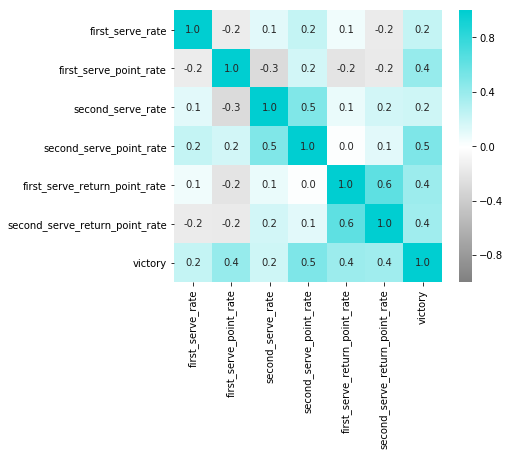

In [159]:
plt.figure(figsize=(6,5))
sns.heatmap(df_tmp.corr(), annot=True, vmax=1, vmin=-1, fmt='.1f', cmap=cm)
plt.show()

In [150]:
x = df_tmp_n[target_cols].values
y = df_tmp_n.index

factor_num = 3
fa = decomposition.FactorAnalysis(n_components=factor_num).fit(x)

df_factor_loading = pd.DataFrame(columns=target_cols)
for i in range(factor_num):
    df_factor_loading = df_factor_loading.append(pd.Series(fa.components_[i], index=target_cols, name='factor'+str(i)))

df_factor_loading

,first_serve_rate,first_serve_point_rate,second_serve_rate,second_serve_point_rate,first_serve_return_point_rate,second_serve_return_point_rate
factor0,-0.020160,-0.220032,0.391780,0.413493,0.601223,0.883986
factor1,-0.203896,-0.467122,-0.304557,-0.827799,0.276294,0.266019
factor2,0.327522,-0.753182,0.441881,0.166780,-0.066059,-0.207630


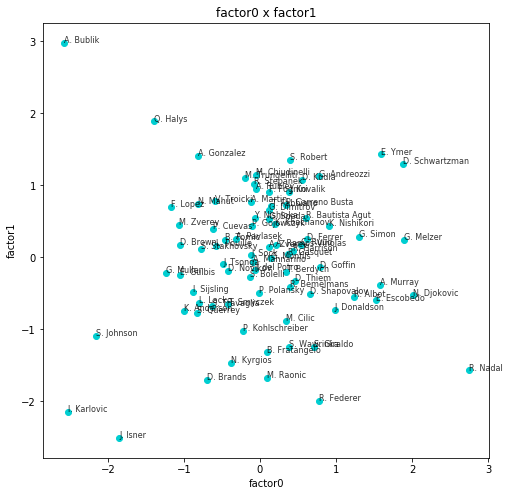

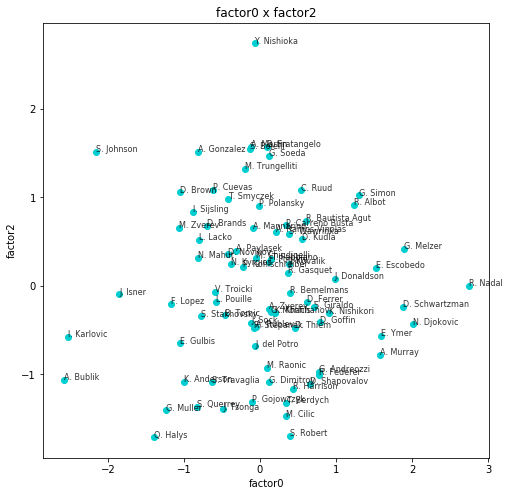

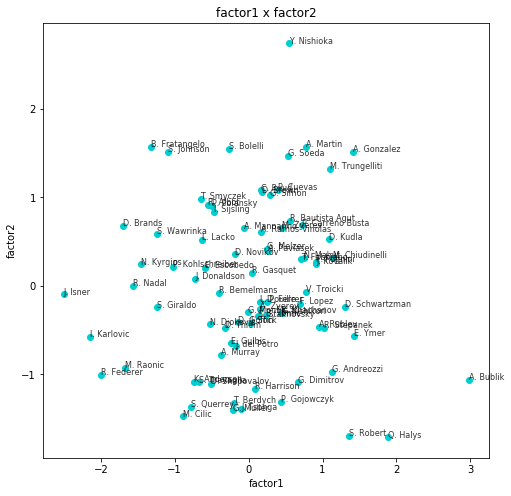

In [176]:
transformed = fa.fit_transform(x)

for i, j in itertools.combinations(np.arange(factor_num), 2):

    plt.figure(figsize=(8,8))
    plt.scatter(transformed[:, i], transformed[:, j], color=base_color)
    for k, y_ in enumerate(y):
        plt.annotate(y_, xy=(transformed[k, i], transformed[k, j]), size=8, alpha=0.8)
    plt.xlabel('factor'+str(i))
    plt.ylabel('factor'+str(j))
    plt.title('factor'+str(i)+' x '+'factor'+str(j))
    plt.show()